In [1]:
import sys
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm

from scipy import io
from findiff import FinDiff
from pysindy.differentiation import SmoothedFiniteDifference

import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
def approximate_noise(Y, lam = 10):

    n,m = Y.shape

    D = np.zeros((m,m))
    D[0,:4] = [2,-5,4,-1]
    D[m-1,m-4:] = [-1,4,-5,2]

    for i in range(1,m-1):
        D[i,i] = -2
        D[i,i+1] = 1
        D[i,i-1] = 1

    D = D.dot(D)

    X_smooth = np.vstack([np.linalg.solve(np.eye(m) + lam*D.T.dot(D), Y[j,:].reshape(m,1)).reshape(1,m) for j in range(n)])

    N_hat = Y-X_smooth

    return N_hat, X_smooth

def preprocess(path, plot_denoise=False):

    # read data
    df = pd.read_csv(path,  header=None)
    
    
    # transfer the x,y coordinates to angules
    theta = np.zeros([df.shape[0], 2])
    data_0 = df.to_numpy()
    data_0[:, 0] = 3000 - data_0[:, 0]
    data_0[:, 2] = 3000 - data_0[:, 2]
    data_0[:, 4] = 3000 - data_0[:, 4]

    for i in range(df.shape[0]):
        theta[i, 0] = math.atan2(data_0[i,2]-data_0[i,0], 
                                 data_0[i,3]-data_0[i,1]) + 0.5*np.pi
        theta[i, 1] = math.atan2(data_0[i,4]-data_0[i,2], 
                                 data_0[i,5]-data_0[i,3]) + 0.5*np.pi
    for i in range(theta.shape[0]):
        for j in range(theta.shape[1]):
            if theta[i, j] > np.pi:
                theta[i, j] = theta[i, j] - 2*np.pi
                
                
    # downsample and shift data
    downsample_rate = 1
    end_t = int((df.shape[0]-1) / 400)

    t = np.linspace(0, end_t, 400*end_t+1)
    x_sample = np.zeros([len(t), 2])

    for i in range(x_sample.shape[0]):
        x_sample[i, :] = theta[i, :]

    x_sample_shift = x_sample.copy()

    for i in range(1, x_sample.shape[0]):
        if abs(x_sample[i, 0] - x_sample[i-1, 0]) >= np.pi:
            x_sample_shift[i:, 0] = x_sample_shift[i:, 0] + 2 * np.pi * np.sign(x_sample[i-1, 0] - x_sample[i, 0])
        if abs(x_sample[i, 1] - x_sample[i-1, 1]) >= np.pi:
            x_sample_shift[i:, 1] = x_sample_shift[i:, 1] + 2 * np.pi * np.sign(x_sample[i-1, 1] - x_sample[i, 1])
            
    
    ##### denoise data #####
    
    # using finite difference to find the derivatives of measurement 
    d_dt = FinDiff(0, 1/400, 1, acc=2)

    omega_1_FD = d_dt(x_sample_shift[:, 0].T).T
    omega_2_FD = d_dt(x_sample_shift[:, 1].T).T

    domega_1_FD = d_dt(omega_1_FD.T).T
    domega_2_FD = d_dt(omega_2_FD.T).T

    # using S-G filter to smooth the derivatives of measurement 
    X = np.vstack((np.sin(t),np.cos(t))).T
    sfd = SmoothedFiniteDifference(smoother_kws={'window_length': 5})
    omega_SG = sfd._differentiate(x_sample_shift, t).T
    omega_1_SG = omega_SG[0, :]
    omega_2_SG = omega_SG[1, :]

    domega_SG = sfd._differentiate(omega_SG.T, t).T
    domega_1_SG = domega_SG[0, :]
    domega_2_SG = domega_SG[1, :]

    # using Laplacian filter to smooth the state variables 
    # and the FD and S-G filter to calculate derivatives 
    _, X_hat = approximate_noise(x_sample_shift.T, lam = 1e3)
    omega = sfd._differentiate(X_hat.T, t).T
    _, omega_hat = approximate_noise(omega, lam = 1e3)
    domega_hat = sfd._differentiate(omega_hat.T, t).T

    omega_1_hat = omega_hat[0, :]
    omega_2_hat = omega_hat[1, :]

    domega_1_hat = domega_hat[0, :]
    domega_2_hat = domega_hat[1, :]
    
    dp_data = np.vstack([X_hat, omega_hat, domega_hat])
    
    
    if plot_denoise:  

        fig = plt.figure(figsize=(16, 6))
        ax = fig.add_subplot(211)
        ax.plot(domega_1_FD[100:600], label = 'Finite difference')
        ax.plot(domega_1_SG[100:600], label = 'Savitzky–Golay filter')
        ax.plot(domega_1_hat[100:600], lw=3, label = 'Laplacian decomposed')
        ax.set_ylabel('$\mathrm{\\theta_1 [\pi \\times rad]}$', fontsize=18)
        ax.axes.xaxis.set_visible(False)
        ax.legend()

        ax = fig.add_subplot(212)
        ax.plot(domega_2_FD[100:600])
        ax.plot(domega_2_SG[100:600])
        ax.plot(domega_2_hat[100:600], lw=3)
        ax.set_ylabel('$\mathrm{\\theta_2 [\pi \\times rad]}$', fontsize=18)
        plt.subplots_adjust(wspace=0.05, hspace=0.05)
        plt.show()

    return dp_data

In [3]:
data_folder = 'data/dp_ibm_raw/original/dpc_dataset_csv/'  ## directory to data folder
dummy_folder = 'data/dp_ibm_raw/denoised_data/'  ## directory to data folder
output_folder = 'data/' ## directory to save results

num_train = 5
num_test = 2

In [4]:
dp_preprocess_f1 = []
dp_preprocess_f2 = []

for i in range(num_train):
    print("\rProcessing dataset {}/{}.".format(i, num_train), end="")
    sys.stdout.flush()
    
    input_dir = data_folder + str(i) + '.csv'
    dp_data = preprocess(input_dir, plot_denoise=False).T
    dp_data_f1 = np.hstack([dp_data[:, :4], dp_data[:, -1:], dp_data[:, -2:-1]])
    
    pd.DataFrame(dp_data).to_csv(dummy_folder + str(i) + '_denoise.csv', index=False, header=False)
    
    dp_preprocess_f2.append(dp_data)
    dp_preprocess_f1.append(dp_data_f1)
    

dp_f1_all = np.vstack(dp_preprocess_f1)
dp_f2_all = np.vstack(dp_preprocess_f2)

np.random.seed(0)
idx = np.random.randint(dp_f1_all.shape[0], size=5000)
dp_f1_train = dp_f1_all[idx, :]
dp_f2_train = dp_f2_all[idx, :]
pd.DataFrame(dp_f1_train).to_csv(output_folder + 'dp_f1_train.csv', index=False, header=False)
pd.DataFrame(dp_f2_train).to_csv(output_folder + 'dp_f2_train.csv', index=False, header=False)

Processing dataset 4/5.

Processing dataset 0/2.

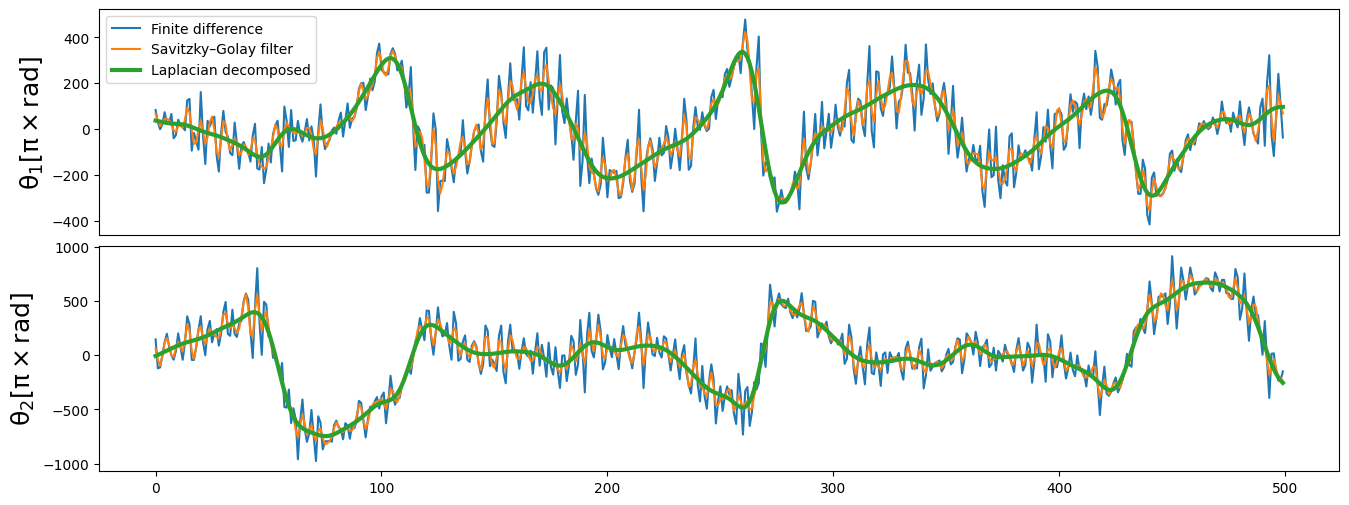

Processing dataset 1/2.

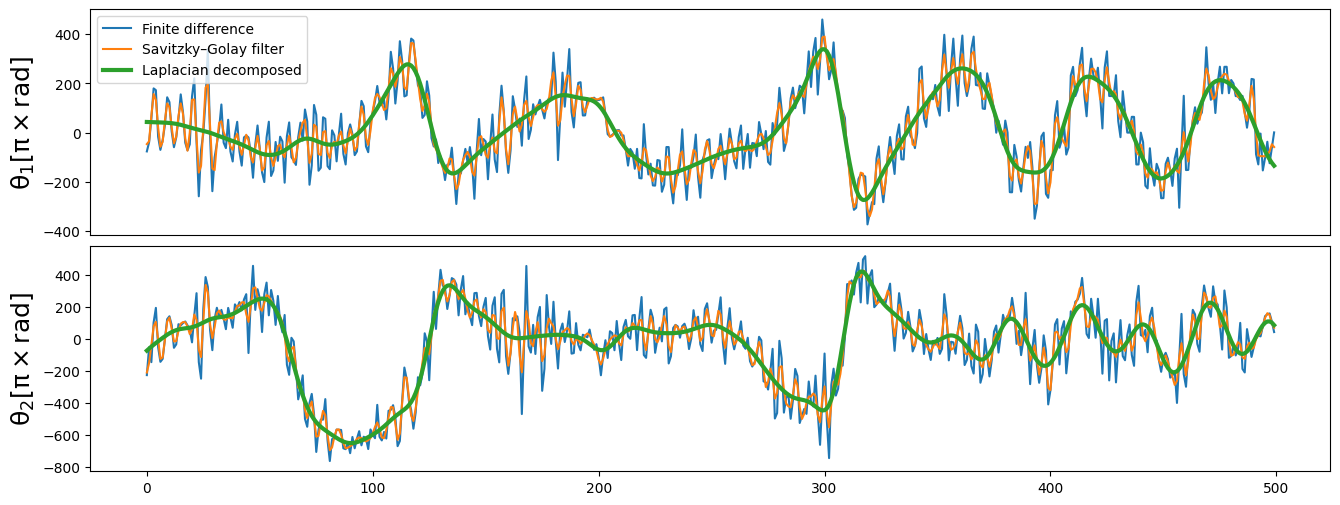

In [5]:
dp_preprocess_f1 = []
dp_preprocess_f2 = []

for i in range(num_train, num_train+num_test):
    print("\rProcessing dataset {}/{}.".format(i-num_train, num_test), end="")
    sys.stdout.flush()
    
    input_dir = data_folder + str(i) + '.csv'
    dp_data = preprocess(input_dir, plot_denoise=True).T
    dp_data_f1 = np.hstack([dp_data[:, :4], dp_data[:, -1:], dp_data[:, -2:-1]])
    
    pd.DataFrame(dp_data).to_csv(dummy_folder + str(i) + '_denoise.csv', index=False, header=False)
    
    dp_preprocess_f2.append(dp_data)
    dp_preprocess_f1.append(dp_data_f1)
    

dp_f1_all = np.vstack(dp_preprocess_f1)
dp_f2_all = np.vstack(dp_preprocess_f2)

np.random.seed(1)
idx = np.random.randint(dp_f1_all.shape[0], size=2000)
dp_f1_test = dp_f1_all[idx, :]
dp_f2_test = dp_f2_all[idx, :]
pd.DataFrame(dp_f1_test).to_csv(output_folder + 'dp_f1_test.csv', index=False, header=False)
pd.DataFrame(dp_f2_test).to_csv(output_folder + 'dp_f2_test.csv', index=False, header=False)